In [77]:
import polars as pl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import sys
work_path = Path(next((p for p in Path("__file__").resolve().parents if p.name == "Research"), None))
torchlib_path = str(work_path / Path("app/torch_libs"))
sys.path.append(torchlib_path)

from run_manager import RunManager, RunsManager, RunViewer


In [78]:
import polars as pl
import random
import string

# ランダムな10文字の文字列を生成する関数
def generate_random_string():
    return ''.join(random.choices(string.ascii_letters + string.digits, k=10))

# CSVファイルを読み込む (例: input.csv)
df = pl.read_csv("/home/haselab/Documents/tat/Research/app/ee_cifar100_dist/exp_cifar100_dist/results.csv")

# 各6つのレコードごとにランダムな文字列を生成してrand_strカラムに追加する
n = len(df)
random_strings = [generate_random_string() for _ in range((n + 5) // 6)]
df = df.with_columns(
    pl.Series("rand_str", [random_strings[i // 6] for i in range(n)])
)

# 結果を確認
print(df)

# CSVファイルに保存 (例: output.csv)
df.write_csv("/home/haselab/Documents/tat/Research/app/ee_cifar100_dist/exp_cifar100_dist/results.csv")

shape: (624, 30)
┌────────┬─────────────┬────────────┬────────────┬───┬───────────┬──────────┬─────────┬────────────┐
│ run_id ┆ model_arc   ┆ train_data ┆ val_datase ┆ … ┆ train_acc ┆ val_loss ┆ val_acc ┆ rand_str   │
│ ---    ┆ ---         ┆ set        ┆ t          ┆   ┆ ---       ┆ ---      ┆ ---     ┆ ---        │
│ i64    ┆ str         ┆ ---        ┆ ---        ┆   ┆ f64       ┆ f64      ┆ f64     ┆ str        │
│        ┆             ┆ str        ┆ str        ┆   ┆           ┆          ┆         ┆            │
╞════════╪═════════════╪════════════╪════════════╪═══╪═══════════╪══════════╪═════════╪════════════╡
│ 102    ┆ models.gitr ┆ cifar100_t ┆ cifar100_v ┆ … ┆ 0.6932    ┆ 0.190502 ┆ 0.578   ┆ M61LT5ykX5 │
│        ┆ esnet_ee    ┆ rain       ┆ al         ┆   ┆           ┆          ┆         ┆            │
│        ┆ resnet18    ┆            ┆            ┆   ┆           ┆          ┆         ┆            │
│ 103    ┆ models.gitr ┆ cifar100_t ┆ cifar100_v ┆ … ┆ 0.7942    ┆ 0.18712

In [79]:
nb_path = Path().resolve()
# rm = RunManager(exp_path=nb_path)
# rm.ref_stats()
rv = RunViewer(exp_path=nb_path)
df_base = rv.fetch_results(refresh=False)

pass


In [80]:
df_res = df_base

cols = ["classdist", "rand_str"]
# cols = ["train_dataset", "train_num", "classdist"]

df_uq = df_res.unique(cols, maintain_order=True).select(cols)

df_res_mf = None

for cond in df_uq.iter_rows(named=True):
    df_cond = df_res
    for k, v in cond.items():
        df_cond = df_cond.filter(pl.col(k) == v)
    
    max_fil = df_cond["fils"].max()
    # min_fil = df_cond["fils"].min()
    max_fil_vacc = df_cond.filter(pl.col("fils") == max_fil)["val_acc"].mean()
    
    df_cond = df_cond.with_columns(pl.lit(max_fil_vacc).alias("val_acc_mf"))
    
    if df_res_mf is None:
        df_res_mf = df_cond
    else:
        df_res_mf = pl.concat([df_res_mf, df_cond], how="vertical")
        


df_res_mf = df_res_mf.with_columns((pl.col("val_acc") - pl.col("val_acc_mf")).alias("mf_diff"))
# df_res_mf = df_res_mf.with_columns((pl.col("val_acc") / pl.col("val_acc_mf")).alias("mf_diff") - 1)
    
# with pl.Config() as cfg:
#     cfg.set_tbl_rows(-1)
#     cfg.set_tbl_cols(-1)
#     display(df_res_mf)



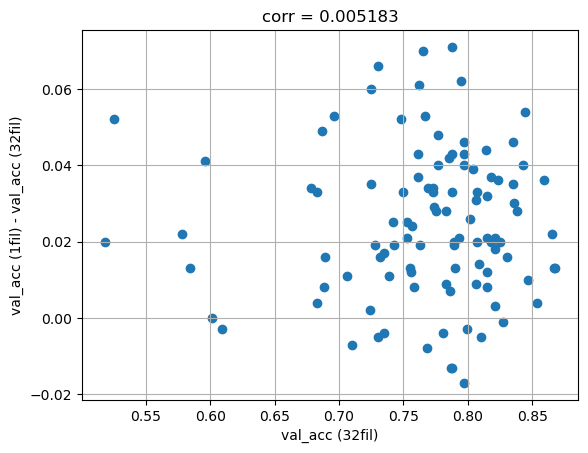

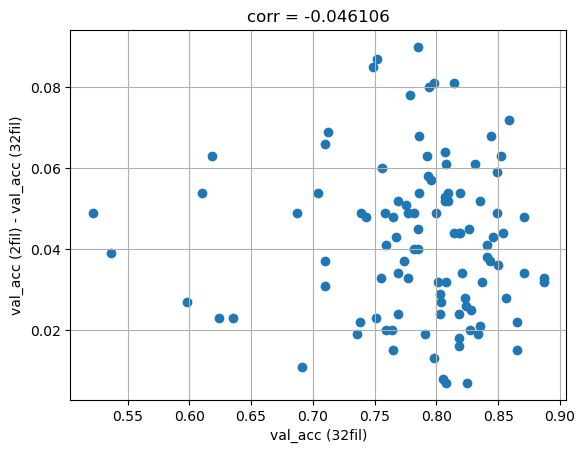

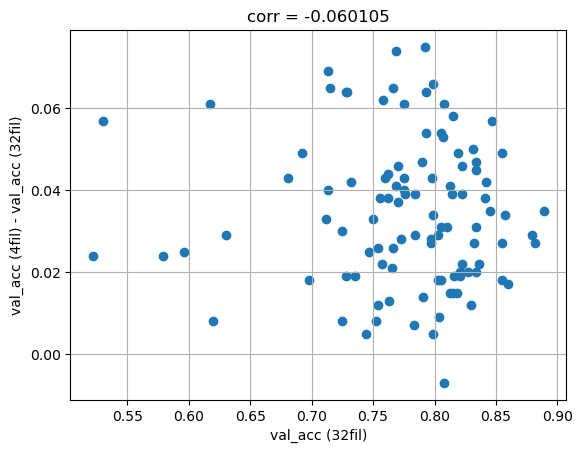

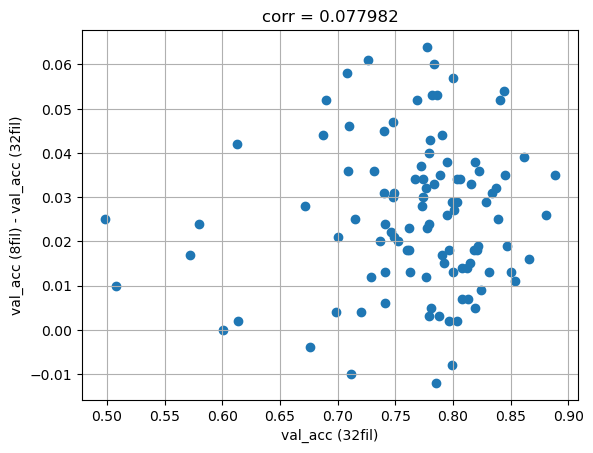

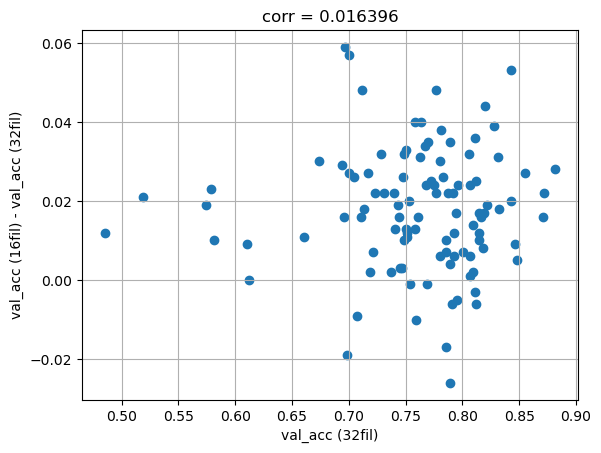

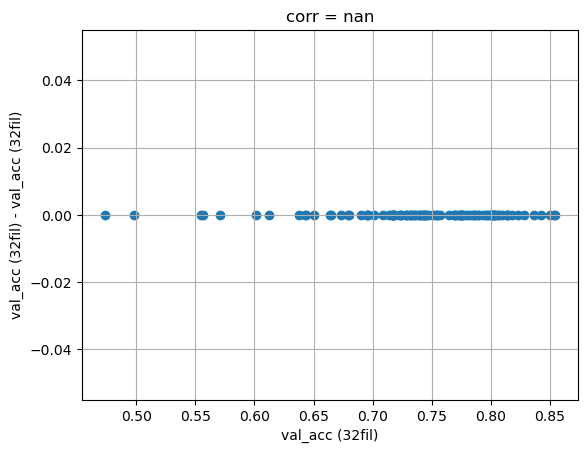

In [81]:
for f in [1, 2, 4, 8, 16, 32]:
    df_res_mft = df_res_mf.filter(pl.col("fils") == f)

    df_res_f1_b = df_res_mft

# df_res_mf = df_res_mf.filter(pl.col("train_num") == 1000)
    df_res_mf = df_res_mf.sort("val_acc", descending=True)

    df_res_f1 = df_res_f1_b.sort("val_acc", descending=True)

    fig, ax = plt.subplots()

# ext_col = "train_num"
    ext_col = "train_dataset"
    x_col = "val_acc"
    # x_col = "classdist"
    y_col = "mf_diff"
# y_col = "classdist"

    for ds in df_res_f1[ext_col].unique(maintain_order=True):
        df_res_ft = df_res_f1.filter(pl.col(ext_col) == ds)
        x = df_res_ft[x_col]
        y = df_res_ft[y_col]

        ax.scatter(x, y, label=ds[:-6])

    # print(np.corrcoef(x, y))

    ax.set_xlabel("val_acc (32fil)")
    ax.set_ylabel(f"val_acc ({f}fil) - val_acc (32fil)")
    ax.set_title(f"corr = {np.corrcoef(x, y)[0, 1]:.6f}")
    ax.grid()
    # fig.legend()
    fig.show()


